In [1]:
import numpy as np
import pandas as pd
import artist_info_helper as aih
import track_info_helper as tih

import glob, os, re, sys
from datetime import datetime
import pickle
import time
import copy
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
plt.style.use('mpl_style_Jeffreson.mplstyle')

In [2]:
# features that we want to analyze
testdict = tih.TrackInfoDict()
features = testdict.keys
features = [feature for feature in features if feature not in ['ids', 'names', 'artists', 'release_date', 'popularity']]
features += ['monthly_listeners', 'days_since_release'] # derived quantities for this notebook
vmins, vmaxs = testdict.vmins, testdict.vmaxs

CRITICAL:track_info_helper:Need to provide both tracks_info and tracks_audio_info to initialize TrackInfoDict.


# load the random track data for the random artist sample

In [3]:
DEFAULT_RND_DIR = "/n/holystore01/LABS/itc_lab/Users/sjeffreson/serch/artist-database/"
df = pd.read_csv(DEFAULT_RND_DIR + "Spotify_artist_info_tracks.csv")
print(df.columns)
df.describe()

Index(['ids', 'names', 'popularity', 'markets', 'artists', 'release_date',
       'duration_ms', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'valence', 'musicalkey', 'musicalmode', 'time_signature'],
      dtype='object')


,popularity,markets,duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,musicalkey,musicalmode,time_signature
count,15013.000000,15013.000000,1.501300e+04,14990.000000,14990.000000,14990.000000,14990.000000,14990.000000,14990.000000,14990.000000,14990.000000,14990.000000,14990.000000,14990.000000,14990.000000
mean,7.978952,180.767135,2.460619e+05,0.318848,0.505802,0.613365,0.290806,0.212452,-9.742385,0.091602,121.113870,0.418403,5.201134,0.628152,3.869513
std,11.281182,24.466770,1.865558e+05,0.354816,0.191411,0.270895,0.375279,0.178687,5.502908,0.120909,30.266883,0.267564,3.567750,0.483314,0.515085
min,0.000000,0.000000,4.305000e+03,0.000000,0.000000,0.000020,0.000000,0.000000,-45.575000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,185.000000,1.647540e+05,0.006842,0.369000,0.416250,0.000009,0.099300,-12.028000,0.036900,98.006250,0.184000,2.000000,0.000000,4.000000
50%,3.000000,185.000000,2.155230e+05,0.138000,0.515000,0.655000,0.013600,0.135000,-8.339000,0.049150,120.638000,0.392000,5.000000,1.000000,4.000000
75%,12.000000,185.000000,2.798130e+05,0.637000,0.651000,0.849000,0.722000,0.283000,-5.995250,0.085275,139.993000,0.630000,8.000000,1.000000,4.000000
max,90.000000,185.000000,7.929036e+06,0.996000,0.975000,1.000000,0.998000,0.989000,3.726000,0.968000,247.887000,0.998000,11.000000,1.000000,5.000000


In [4]:
# convert release date to years since release
days_since_release, num_old_tracks = [], 0
for date in df.release_date:
    try:
        days_since_release.append((datetime.now() - datetime.strptime(date, '%Y-%m-%d')).days)
    except ValueError:
        try:
            days_since_release.append((datetime.now() - datetime.strptime(date, '%Y-%m')).days)
        except ValueError:
            try:
                days_since_release.append((datetime.now() - datetime.strptime(date, '%Y')).days)
            except ValueError:
                print(date)
df['days_since_release'] = days_since_release

In [5]:
# convert duration to minutes
df['duration_ms'] = df['duration_ms'] / 60000

# convert days since release to years since release
df['days_since_release'] = df['days_since_release'] / 365

In [6]:
# load the monthly listeners associated with the track artist ids
df_mnth_lstnrs = pd.read_csv(DEFAULT_RND_DIR + "CLEANED_Spotify_artist_info_Mnth-Lstnrs.csv",
                             usecols=['ids', 'monthly_listeners', 'last_release', 'first_release', 'num_releases'],
                             dtype={'ids': str, 'monthly_listeners': float, 'last_release': int, 'first_release': int, 'num_releases': int})
# select active artists
df_mnth_lstnrs = df_mnth_lstnrs[df_mnth_lstnrs['last_release'] > 2019]
cnd = (
    (df_mnth_lstnrs['num_releases'] >= 1.*(df_mnth_lstnrs['last_release'] - df_mnth_lstnrs['first_release'])) &
    (2024-df_mnth_lstnrs['first_release'] > 1)
) | (2024-df_mnth_lstnrs['first_release'] <= 1)
df_mnth_lstnrs = df_mnth_lstnrs[cnd]

# delete all columns but ids and monthly listeners
df_mnth_lstnrs = df_mnth_lstnrs[['ids', 'monthly_listeners']]

df_mnth_lstnrs.set_index('ids', inplace=True)
df_mnth_lstnrs.describe()

,monthly_listeners
count,6.239000e+03
mean,4.242662e+05
std,2.668259e+06
min,0.000000e+00
25%,1.027000e+03
50%,1.443500e+04
75%,1.008890e+05
max,8.135858e+07


In [7]:
monthly_listeners, not_found = [], 0
for ids in df.artists:
    monthly_listeners_ = []
    for id in ids.replace(" ", "").split(','):
        try:
            val = df_mnth_lstnrs.loc[id].values[0]
        except KeyError:
            val = -1
        monthly_listeners_.append(val)
    monthly_listeners.append(max(monthly_listeners_))
df['monthly_listeners'] = monthly_listeners
print(f"Number of artists not found: {not_found}")

Number of artists not found: 0


In [8]:
# print number of artists with zero monthly listeners
print("Number of artists with zero monthly listeners: ", len(df[df['monthly_listeners'] == 0]))

# and with no or NaN days since release
print("Number of artists with no days since release: ", len(df[df['days_since_release'] == 0]))
print("Number of artists with NaN days since release: ", len(df[df['days_since_release'].isna()]))

Number of artists with zero monthly listeners:  15
Number of artists with no days since release:  0
Number of artists with NaN days since release:  0


In [9]:
# drop NA values for the numerical properties, and 0 Monthly Listeners
df = df.dropna(subset=[column for column in df.columns if column in features])
df = df.drop(df[df['monthly_listeners'] <= 0].index)
df.describe()

,popularity,markets,duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,musicalkey,musicalmode,time_signature,days_since_release,monthly_listeners
count,6119.000000,6119.000000,6119.000000,6119.000000,6119.000000,6119.000000,6119.000000,6119.000000,6119.000000,6119.000000,6119.000000,6119.000000,6119.000000,6119.000000,6119.000000,6119.000000,6.119000e+03
mean,11.560386,181.857166,3.778077,0.291502,0.530575,0.616604,0.291683,0.205457,-9.460118,0.099763,121.612594,0.390786,5.205916,0.591273,3.894427,2.436323,4.156162e+05
std,13.405265,21.348052,2.496817,0.337914,0.193100,0.261113,0.379574,0.167770,5.382332,0.124220,30.150791,0.256125,3.593712,0.491639,0.474557,2.587255,2.578038e+06
min,0.000000,0.000000,0.233333,0.000001,0.000000,0.000334,0.000000,0.019300,-45.575000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.156164,1.000000e+00
25%,1.000000,185.000000,2.611442,0.007685,0.398000,0.435000,0.000004,0.100000,-11.537500,0.037800,98.032500,0.166000,2.000000,0.000000,4.000000,0.682192,1.040000e+03
50%,6.000000,185.000000,3.369333,0.117000,0.547000,0.654000,0.009840,0.131000,-8.105000,0.051100,122.002000,0.364000,5.000000,1.000000,4.000000,1.663014,1.472700e+04
75%,19.000000,185.000000,4.296342,0.549000,0.680000,0.838000,0.739000,0.272000,-5.964000,0.098600,140.057500,0.578000,8.000000,1.000000,4.000000,3.387671,1.046910e+05
max,90.000000,185.000000,66.600000,0.996000,0.971000,1.000000,0.997000,0.984000,3.587000,0.962000,247.887000,0.992000,11.000000,1.000000,5.000000,33.835616,8.135858e+07


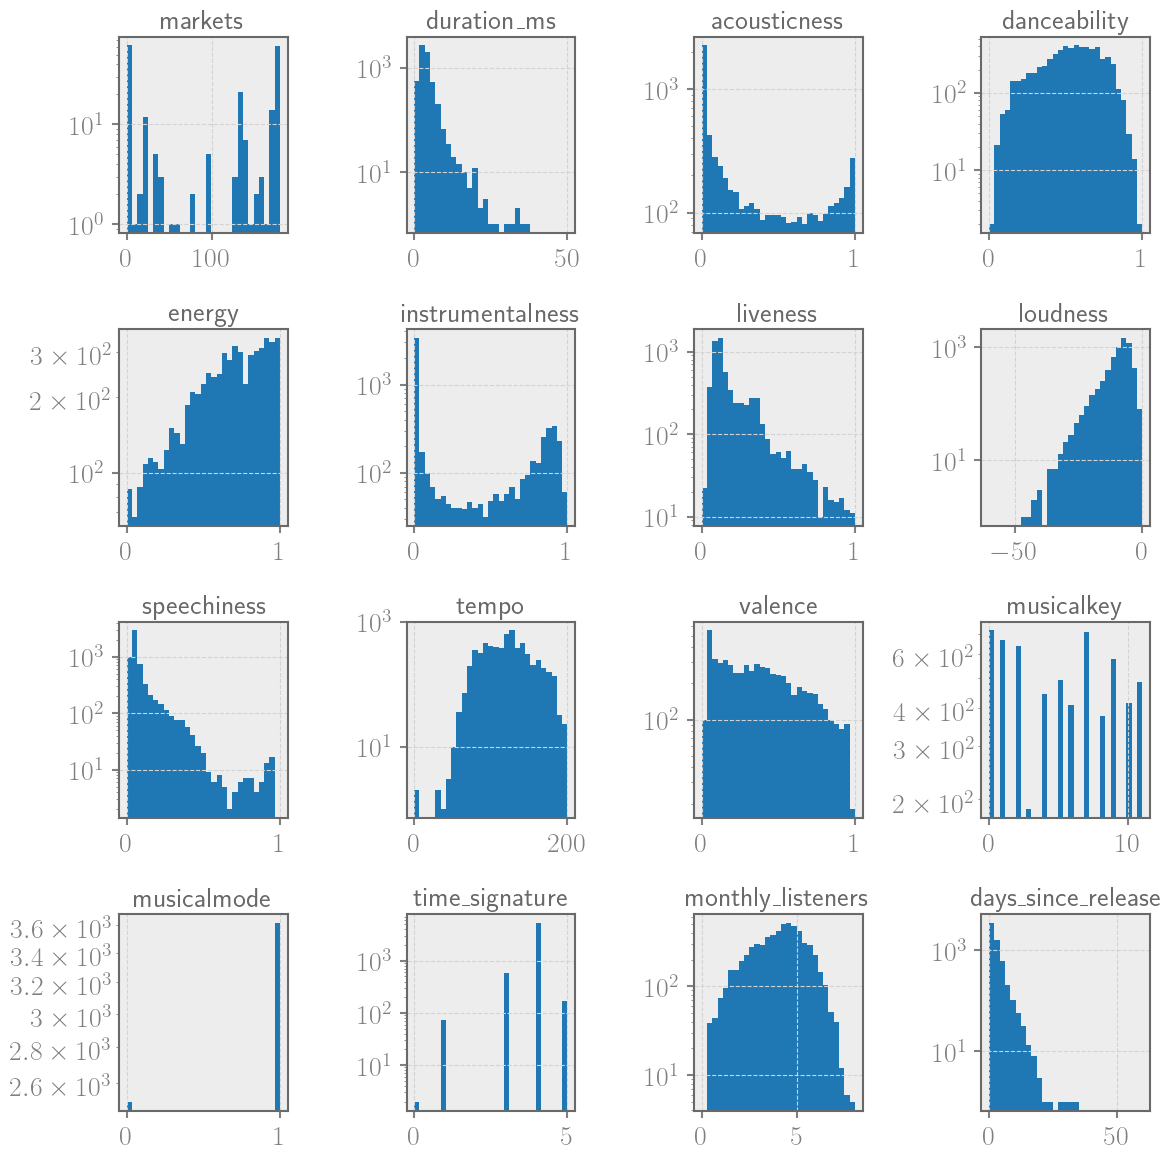

In [10]:
# Create a figure and a grid of subplots
fig, axs = plt.subplots(4, 4, figsize=(12, 12))

# Plot on each subplot
for i in range(4):
    for j in range(4):
        featureno = 4*i + j
        vmin, vmax = vmins[features[featureno]], vmaxs[features[featureno]]
        if features[featureno] == 'monthly_listeners':
            axs[i,j].hist(np.log10(df[features[featureno]]+1), bins=np.linspace(np.log10(vmin+1), np.log10(vmax), 30), log=True, lw=2)
        else:
            axs[i,j].hist(df[features[featureno]], bins=np.linspace(vmin, vmax, 30), log=True, lw=2)
        axs[i,j].set_title(features[featureno])

plt.tight_layout()
plt.show()

# load the editorial data for the dates that exist

In [11]:
DEFAULT_EDIT_DIR = "/n/holystore01/LABS/itc_lab/Users/sjeffreson/serch/artist-database/Editorial-playlists/"
df_edit = pd.read_csv(DEFAULT_EDIT_DIR + "featured_Spotify_track_info.csv")
print(df_edit.columns)
df_edit.describe()

Index(['ids', 'names', 'popularity', 'markets', 'artists', 'release_date',
       'duration_ms', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'valence', 'musicalkey', 'musicalmode', 'time_signature', 'count',
       'dates', 'playlists_found'],
      dtype='object')


,popularity,markets,duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,musicalkey,musicalmode,time_signature,count
count,15052.000000,15052.000000,1.505200e+04,15038.000000,15038.000000,15038.000000,15038.000000,15038.000000,15038.000000,15038.000000,15038.000000,15038.000000,15038.000000,15038.000000,15038.000000,15052.000000
mean,50.134135,173.076202,2.005013e+05,0.365888,0.567015,0.556783,0.234196,0.167943,-10.811701,0.082969,119.348263,0.426425,5.180410,0.656736,3.906171,2.283750
std,17.968905,42.644276,5.827816e+04,0.368929,0.191950,0.296156,0.373847,0.127240,9.307152,0.085919,30.134097,0.253584,3.556735,0.474814,0.428005,2.438549
min,0.000000,0.000000,1.466000e+03,0.000001,0.000000,0.000020,0.000000,0.012400,-50.051000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,39.000000,184.000000,1.630338e+05,0.029500,0.453000,0.366000,0.000000,0.098100,-11.157000,0.036400,96.005250,0.212000,2.000000,0.000000,4.000000,1.000000
50%,50.000000,185.000000,1.923360e+05,0.203000,0.590000,0.620000,0.000361,0.115000,-7.291000,0.047900,120.386000,0.406000,5.000000,1.000000,4.000000,1.000000
75%,63.000000,185.000000,2.271950e+05,0.719000,0.709000,0.798000,0.496750,0.188000,-5.291250,0.084275,139.403000,0.624000,8.000000,1.000000,4.000000,2.000000
max,100.000000,185.000000,1.160720e+06,0.996000,0.978000,0.999000,0.995000,0.975000,1.827000,0.885000,219.984000,0.986000,11.000000,1.000000,5.000000,33.000000


In [12]:
# dataframe with the monthly listeners for each artist
df_edit_mnth_listeners = pd.read_csv(DEFAULT_EDIT_DIR + "featured_Spotify_artist_info.csv")
df_edit_mnth_listeners.set_index('ids', inplace=True)

In [13]:
# convert duration to mins
df_edit['duration_ms'] = df_edit['duration_ms'] / 60000

In [14]:
# for track info at each date, load the monthly listeners of the associated artist on that date
# (many artists are featured multiple times in one month)
monthly_listeners, not_found = [], 0
for ids in df_edit.artists:
    monthly_listeners_ = []
    for id in ids.replace(" ", "").split(','):
        try:
            val = np.median(df_edit_mnth_listeners.loc[id]['monthly_listeners']) # take median of value at all times featured
        except KeyError:
            val = -1
            not_found += 1
        monthly_listeners_.append(val)
    monthly_listeners.append(np.median(monthly_listeners_)) # if multiple artists found, take the median
print(f"Number of artists not found: {not_found}") # possible for artists on collaborative tracks that only appear on that one track
df_edit['monthly_listeners'] = monthly_listeners

Number of artists not found: 1739


In [16]:
# convert release date to years since release
days_since_release, num_old_tracks = [], 0
for date in df_edit.release_date:
    try:
        days_since_release.append((datetime.now() - datetime.strptime(date, '%Y-%m-%d')).days)
    except ValueError:
        try:
            days_since_release.append((datetime.now() - datetime.strptime(date, '%Y-%m')).days)
        except ValueError:
            days_since_release.append((datetime.now() - datetime.strptime(date, '%Y')).days)
df_edit['days_since_release'] = days_since_release

In [17]:
# convert days since release to years since release
df_edit['days_since_release'] = df_edit['days_since_release'] / 365

In [18]:
# drop NA and -1 values for the numerical properties
df_edit = df_edit.dropna(subset=[column for column in df_edit.columns if column in features])
df_edit = df_edit.drop_duplicates(subset=['ids'])
df_edit.describe()

,popularity,markets,duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,musicalkey,musicalmode,time_signature,count,monthly_listeners,days_since_release
count,14905.000000,14905.000000,14905.000000,14905.000000,14905.000000,14905.000000,14905.000000,14905.000000,14905.000000,14905.000000,14905.000000,14905.000000,14905.000000,14905.000000,14905.000000,14905.000000,1.490500e+04,14905.000000
mean,50.117142,173.110500,3.345412,0.366718,0.566254,0.555971,0.235648,0.167832,-10.844530,0.083008,119.330376,0.425751,5.178732,0.657565,3.905871,2.267897,6.769958e+06,4.890191
std,17.890058,42.606641,0.969506,0.369521,0.192179,0.296758,0.374672,0.127172,9.334593,0.086083,30.183389,0.253688,3.556309,0.474540,0.429156,2.414581,1.424003e+07,9.670246
min,0.000000,0.000000,0.516667,0.000001,0.000000,0.000020,0.000000,0.012400,-50.051000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-1.000000e+00,0.183562
25%,39.000000,184.000000,2.718983,0.029500,0.452000,0.364000,0.000000,0.098100,-11.199000,0.036400,95.999000,0.210000,2.000000,0.000000,4.000000,1.000000,1.469640e+05,0.432877
50%,50.000000,185.000000,3.206617,0.204000,0.589000,0.619000,0.000377,0.115000,-7.298000,0.047900,120.362000,0.405000,5.000000,1.000000,4.000000,1.000000,7.804600e+05,1.142466
75%,63.000000,185.000000,3.787483,0.723000,0.708000,0.798000,0.514000,0.187000,-5.296000,0.084200,139.531000,0.624000,8.000000,1.000000,4.000000,2.000000,5.787128e+06,3.572603
max,100.000000,185.000000,19.345333,0.996000,0.978000,0.999000,0.995000,0.975000,1.827000,0.885000,219.984000,0.986000,11.000000,1.000000,5.000000,33.000000,1.130671e+08,70.208219


In [19]:
feature_titles = {
    'acousticness': 'Acousticness',
    'danceability': 'Danceability',
    'energy': 'Energy',
    'instrumentalness': 'Instrumentalness',
    'liveness': 'Liveness',
    'loudness': 'Loudness',
    'speechiness': 'Speechiness',
    'tempo': 'Tempo',
    'valence': 'Valence',
    'popularity': 'Popularity',
    'duration_ms': 'Duration (ms)',
    'musicalkey': 'Key',
    'musicalmode': 'Mode (Minor/Major)',
    'time_signature': 'Time Signature',
    'monthly_listeners': 'log(Monthly Listeners)',
    'markets': 'Markets',
    'days_since_release': 'Days Since Release',
}

In [20]:
features = [feature for feature in features if feature in df_edit.columns]
features = sorted(features, key=lambda x: np.fabs(vmaxs[x]-vmins[x]))

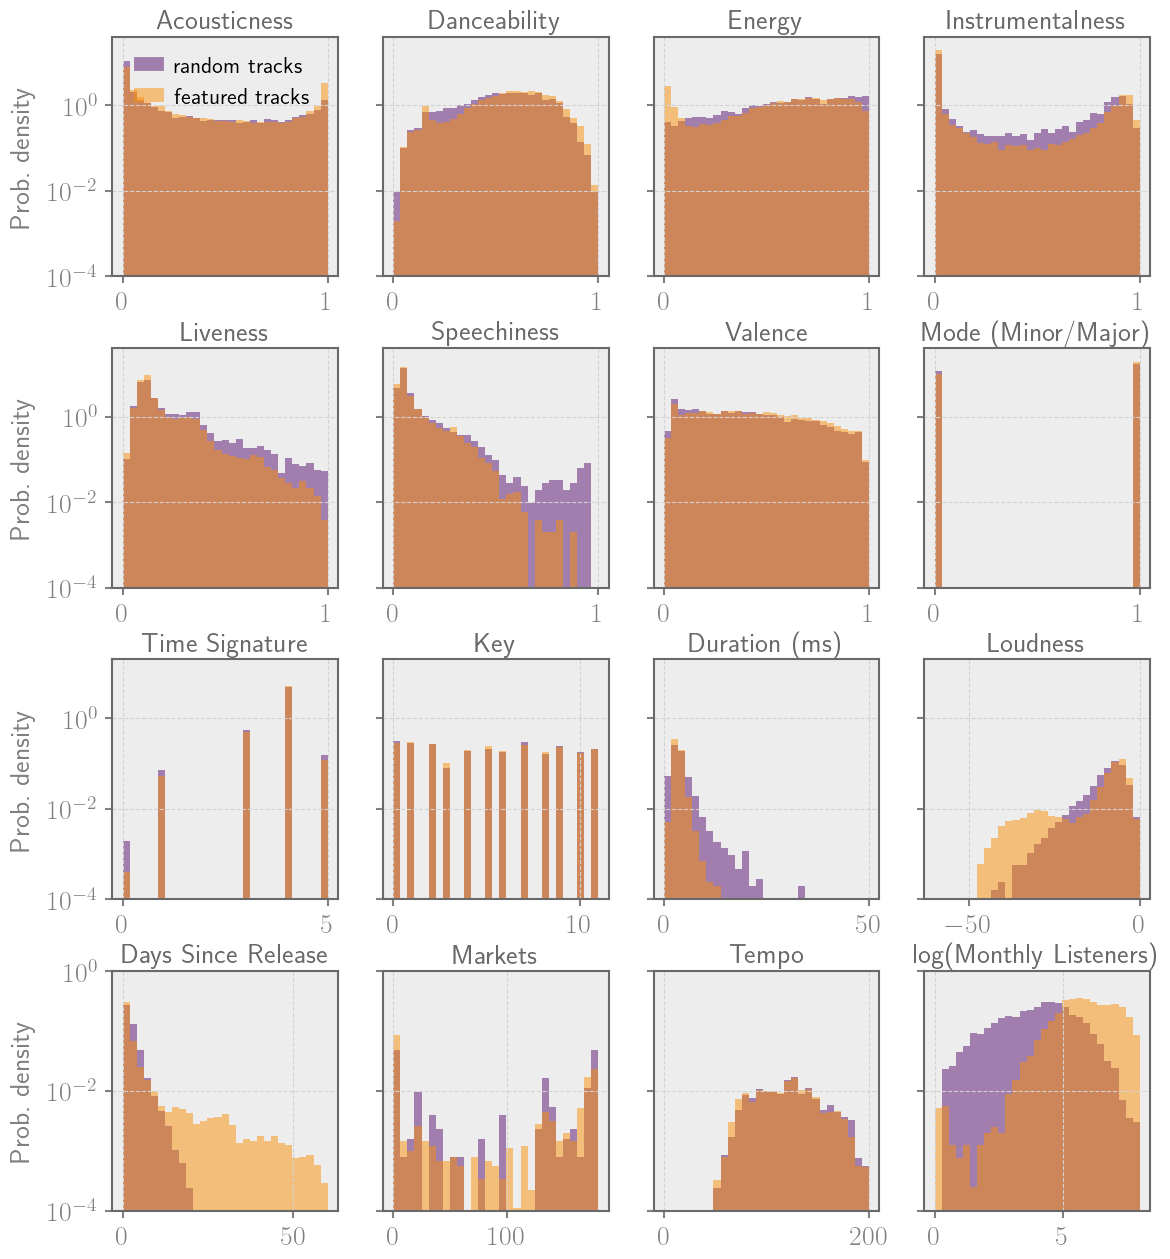

In [34]:
# Create a figure and a grid of subplots
fig, axs = plt.subplots(4, 4, figsize=(12, 13))

# Plot on each subplot
for i in range(4):
    for j in range(4):
        featureno = 4*i + j
        vmin, vmax = vmins[features[featureno]], vmaxs[features[featureno]]
        if features[featureno] == 'monthly_listeners':
            axs[i,j].hist(np.log10(df[features[featureno]]+1), bins=np.linspace(np.log10(vmin+1), np.log10(vmax), 30),
                          log=True, lw=2, alpha=0.5, color=plt.cm.inferno(0.25), density=True)
            axs[i,j].hist(np.log10(df_edit[features[featureno]]+1), bins=np.linspace(np.log10(vmin+1), np.log10(vmax), 30),
                          log=True, lw=2, alpha=0.5, color=plt.cm.inferno(0.75), density=True)
        else:
            axs[i,j].hist(df[features[featureno]], bins=np.linspace(vmin, vmax, 30),
                          log=True, lw=2, alpha=0.5, color=plt.cm.inferno(0.25), density=True)
            axs[i,j].hist(df_edit[features[featureno]], bins=np.linspace(vmin, vmax, 30),
                          log=True, lw=2, alpha=0.5, color=plt.cm.inferno(0.75), density=True)
        if i<2:
            axs[i,j].set_ylim([1.e-4, 40.])
        elif i==2:
            axs[i,j].set_ylim([1.e-4, 20.])
        else:
            axs[i,j].set_ylim([1.e-4, 1.])
        axs[i,j].set_title(feature_titles[features[featureno]])
        if j>0:
            axs[i,j].set_yticklabels([])
        else:
            axs[i,j].set_ylabel('Prob.~density')

# add a custom legend to the first axis
axs[0,0].plot([], [], lw=10, color=plt.cm.inferno(0.25), label='random tracks', alpha=0.5)
axs[0,0].plot([], [], lw=10, color=plt.cm.inferno(0.75), label='featured tracks', alpha=0.5)
axs[0,0].legend(loc='upper center', fontsize=16, frameon=False, handlelength=0.7, ncols=1)

plt.tight_layout()
plt.subplots_adjust(wspace=0.2, hspace=0.3)

plt.savefig("/n/holystore01/LABS/itc_lab/Users/sjeffreson/serch/figs/track_properties.png",
            format='png', bbox_inches='tight', dpi=200)
plt.show()